<a href="https://colab.research.google.com/github/belovelace/AI-study/blob/main/UCI_HAR_ResNet1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [34]:
# 파일 가져오기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
data_path = '/content/drive/MyDrive/AI_study/UCI HAR Dataset/'

print("현재 파일들:")
print(os.listdir(data_path))

현재 파일들:
['.DS_Store', 'README.txt', 'features_info.txt', 'features.txt', 'activity_labels.txt', 'test', 'train']


In [36]:
# train 폴더 안 확인
print("train 폴더:")
print(os.listdir(data_path + 'train/'))
print()

# test 폴더 안 확인
print("test 폴더:")
print(os.listdir(data_path + 'test/'))

train 폴더:
['subject_train.txt', 'y_train.txt', 'X_train.txt', 'Inertial Signals']

test 폴더:
['y_test.txt', 'subject_test.txt', 'X_test.txt', 'Inertial Signals']


In [37]:
# train 폴더 안 확인
print("train 폴더:")
print(os.listdir(data_path + 'train/'))
print()

# test 폴더 안 확인
print("test 폴더:")
print(os.listdir(data_path + 'test/'))

train 폴더:
['subject_train.txt', 'y_train.txt', 'X_train.txt', 'Inertial Signals']

test 폴더:
['y_test.txt', 'subject_test.txt', 'X_test.txt', 'Inertial Signals']


In [38]:
# Inertial Signals 폴더 안 확인
print("train/Inertial Signals 폴더:")
print(os.listdir(data_path + 'train/Inertial Signals/'))

train/Inertial Signals 폴더:
['body_acc_x_train.txt', 'body_acc_y_train.txt', 'total_acc_z_train.txt', 'body_gyro_x_train.txt', 'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'body_gyro_y_train.txt', 'total_acc_x_train.txt', 'total_acc_y_train.txt']


In [39]:
print("y_train.txt 앞부분:")
y_train = pd.read_csv(data_path + 'train/y_train.txt', header=None)
print(y_train.head())
print(f"라벨 종류: {y_train[0].unique()}")

y_train.txt 앞부분:
   0
0  5
1  5
2  5
3  5
4  5
라벨 종류: [5 4 6 1 3 2]


# ResNet1D

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock1D(nn.Module):
    """기본 ResNet Block (1D 버전)"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock1D, self).__init__()

        # 첫 번째 Conv1D
        self.conv1 = nn.Conv1d(in_channels, out_channels,
                              kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        # 두 번째 Conv1D
        self.conv2 = nn.Conv1d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Skip connection을 위한 차원 맞추기
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )



    def forward(self, x):
        residual = x

        # 첫 번째 conv block
        out = F.relu(self.bn1(self.conv1(x)))
        # 두 번째 conv block (ReLU 전에 residual 더하기)
        out = self.bn2(self.conv2(out))

        # Skip connection
        out += self.shortcut(residual)
        out = F.relu(out)

        return out

In [56]:
import torch.nn as nn
import torch.nn.functional as F

class ResNet1D_HAR(nn.Module):
    def __init__(self, num_classes=6):
        super(ResNet1D_HAR, self).__init__()

        # 초기 conv layer
        self.conv1 = nn.Conv1d(6, 16, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(16)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # ResNet layers [2, 2, 2]
        self.layer1 = self._make_layer(16, 16, 2, stride=1)    # 16채널 유지
        self.layer2 = self._make_layer(16, 32, 2, stride=2)    # 32채널로 증가
        self.layer3 = self._make_layer(32, 64, 2, stride=2)    # 64채널로 증가

        # 분류기
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []

        # 첫 번째 블록 (stride 적용)
        layers.append(BasicBlock1D(in_channels, out_channels, stride))

        # 나머지 블록들 (stride=1)
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(out_channels, out_channels, stride=1))

        return nn.Sequential(*layers)

    def forward(self, x):
        # 입력: (batch, 6, 128)
        x = F.relu(self.bn1(self.conv1(x)))      # (batch, 16, 64)
        x = self.maxpool(x)                      # (batch, 16, 32)

        x = self.layer1(x)                       # (batch, 16, 32)
        x = self.layer2(x)                       # (batch, 32, 16)
        x = self.layer3(x)                       # (batch, 64, 8)

        x = self.avgpool(x)                      # (batch, 64, 1)
        x = torch.flatten(x, 1)                  # (batch, 64)
        x = self.fc(x)                           # (batch, 6)

        return x

# 모델 생성
model = ResNet1D_HAR(num_classes=6)

In [57]:
# 모델 생성 및 확인
model = ResNet1D_HAR(num_classes=6)
print(f"총 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

# 입력 테스트
test_input = torch.randn(32, 6, 128)  # batch_size=32
output = model(test_input)
print(f"입력 shape: {test_input.shape}")
print(f"출력 shape: {output.shape}")

총 파라미터 수: 61,574
입력 shape: torch.Size([32, 6, 128])
출력 shape: torch.Size([32, 6])


In [58]:
try:
    from torchsummary import summary
except ImportError:
    print("torchsummary 라이브러리가 설치되어 있지 않습니다. 설치를 진행합니다.")
    !pip install torchsummary
    from torchsummary import summary

# 모델 요약 출력
# 입력 데이터의 shape은 (batch_size, channels, sequence_length) 입니다.
# 이전에 확인한 X_train의 shape이 (7352, 6, 128) 이므로, input_size는 (6, 128)입니다.
print(model)
summary(model, input_size=(6, 128))

ResNet1D_HAR(
  (conv1): Conv1d(6, 16, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock1D(
      (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock1D(
      (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=

## 왜 body_acc + body_gyro를 합치는가?
ResNet1D 모델의 입력 요구사항:
</br>
pythonself.conv1 = nn.Conv1d(6, 16, ...)  # 입력 채널이 6개
</br>
현재 우리가 가진 데이터:
</br>
body_acc: 3축 (x, y, z) - 가속도계
</br>
body_gyro: 3축 (x, y, z) - 자이로스코프

### 합치는 이유:

완전한 센서 정보: 가속도 + 회전 속도 모두 활용
</br>
더 나은 활동 구분:
</br>
가속도만으로는 구분 어려운 활동들 (예: 앉기 vs 서기)
회전 정보가 추가되면 더 정확한 판별 가능


모델 설계와 일치: 6채널 입력으로 설계했으니까
</br>
대안:
</br>
가속도만 사용: 3채널 (정보 부족할 수 있음)
각각 따로 모델: 복잡함

실제로 HAR 연구에서는 거의 항상 가속도+자이로 함께 사용합니다.

In [59]:
# 1. 데이터 로딩 (6축 센서 합치기)
import numpy as np
import pandas as pd

# 파일 경로 정의
train_data_path = data_path + 'train/Inertial Signals/'
test_data_path = data_path + 'test/Inertial Signals/'

# body_acc 데이터 로딩 (Train)
body_acc_x_train = pd.read_csv(train_data_path + 'body_acc_x_train.txt', header=None, delim_whitespace=True)
body_acc_y_train = pd.read_csv(train_data_path + 'body_acc_y_train.txt', header=None, delim_whitespace=True)
body_acc_z_train = pd.read_csv(train_data_path + 'body_acc_z_train.txt', header=None, delim_whitespace=True)

# body_gyro 데이터 로딩 (Train)
body_gyro_x_train = pd.read_csv(train_data_path + 'body_gyro_x_train.txt', header=None, delim_whitespace=True)
body_gyro_y_train = pd.read_csv(train_data_path + 'body_gyro_y_train.txt', header=None, delim_whitespace=True)
body_gyro_z_train = pd.read_csv(train_data_path + 'body_gyro_z_train.txt', header=None, delim_whitespace=True)

# body_acc + body_gyro 합치기 (Train)
X_train = np.stack([
    body_acc_x_train.values,
    body_acc_y_train.values,
    body_acc_z_train.values,
    body_gyro_x_train.values,
    body_gyro_y_train.values,
    body_gyro_z_train.values
], axis=1)

# y_train 라벨 로딩
y_train_orig = pd.read_csv(data_path + 'train/y_train.txt', header=None)
y_train_labels = y_train_orig.values.flatten() - 1  # 0~5로 변경 (원래 1~6)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train_labels.shape}")

# --- Test Data Loading (for Validation) ---

# body_acc 데이터 로딩 (Test)
body_acc_x_test = pd.read_csv(test_data_path + 'body_acc_x_test.txt', header=None, delim_whitespace=True)
body_acc_y_test = pd.read_csv(test_data_path + 'body_acc_y_test.txt', header=None, delim_whitespace=True)
body_acc_z_test = pd.read_csv(test_data_path + 'body_acc_z_test.txt', header=None, delim_whitespace=True)

# body_gyro 데이터 로딩 (Test)
body_gyro_x_test = pd.read_csv(test_data_path + 'body_gyro_x_test.txt', header=None, delim_whitespace=True)
body_gyro_y_test = pd.read_csv(test_data_path + 'body_gyro_y_test.txt', header=None, delim_whitespace=True)
body_gyro_z_test = pd.read_csv(test_data_path + 'body_gyro_z_test.txt', header=None, delim_whitespace=True)

# body_acc + body_gyro 합치기 (Test)
X_test = np.stack([
    body_acc_x_test.values,
    body_acc_y_test.values,
    body_acc_z_test.values,
    body_gyro_x_test.values,
    body_gyro_y_test.values,
    body_gyro_z_test.values
], axis=1)

# y_test 라벨 로딩
y_test_orig = pd.read_csv(data_path + 'test/y_test.txt', header=None)
y_test_labels = y_test_orig.values.flatten() - 1 # 0~5로 변경 (원래 1~6)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test_labels.shape}")

/tmp/ipython-input-2123290521.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  body_acc_x_train = pd.read_csv(train_data_path + 'body_acc_x_train.txt', header=None, delim_whitespace=True)
/tmp/ipython-input-2123290521.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  body_acc_y_train = pd.read_csv(train_data_path + 'body_acc_y_train.txt', header=None, delim_whitespace=True)
/tmp/ipython-input-2123290521.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  body_acc_z_train = pd.read_csv(train_data_path + 'body_acc_z_train.txt', header=None, delim_whitespace=True)
/tmp/ipython-input-2123290521.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be remove

X_train shape: (7352, 6, 128)
y_train shape: (7352,)


/tmp/ipython-input-2123290521.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  body_acc_x_test = pd.read_csv(test_data_path + 'body_acc_x_test.txt', header=None, delim_whitespace=True)
/tmp/ipython-input-2123290521.py:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  body_acc_y_test = pd.read_csv(test_data_path + 'body_acc_y_test.txt', header=None, delim_whitespace=True)
/tmp/ipython-input-2123290521.py:41: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  body_acc_z_test = pd.read_csv(test_data_path + 'body_acc_z_test.txt', header=None, delim_whitespace=True)
/tmp/ipython-input-2123290521.py:44: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a fu

X_test shape: (2947, 6, 128)
y_test shape: (2947,)


## 학습

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

# 1. 데이터를 PyTorch tensor로 변환
X_train_tensor = torch.FloatTensor(X_train)  # (7352, 6, 128)
y_train_tensor = torch.LongTensor(y_train_labels)  # (7352,)
X_test_tensor = torch.FloatTensor(X_test)    # (2947, 6, 128)
y_test_tensor = torch.LongTensor(y_test_labels)    # (2947,)

# 2. Dataset & DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False) # 셔플 필요 없음

# 3. Loss function과 Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)

# 스케줄러 추가
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

# 4. 에포크별 훈련 루프
num_epochs = 10

# 학습 및 검증 기록을 저장할 리스트
epoch_losses = []
epoch_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # --- Training ----
    model.train() # 모델을 훈련 모드로 설정
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    epoch_losses.append(avg_loss)
    epoch_accuracies.append(accuracy)

    # --- Validation ---
    model.eval() # 모델을 평가 모드로 설정 (dropout, batchnorm 비활성화)
    val_total_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad(): # 역전파 계산 비활성화
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)

            val_total_loss += loss.item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    avg_val_loss = val_total_loss / len(test_loader)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # 스케줄러 업데이트 (검증 손실 사용)
    scheduler.step(avg_val_loss)

    # 에포크 결과 출력
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_loss:.4f}, Train Acc = {accuracy:.2f}% | Val Loss = {avg_val_loss:.4f}, Val Acc = {val_accuracy:.2f}%')

# 이제 epoch_losses, epoch_accuracies, val_losses, val_accuracies 리스트에 모든 데이터가 저장됩니다.

Epoch 1/10: Train Loss = 0.8777, Train Acc = 57.78% | Val Loss = 0.6568, Val Acc = 64.37%
Epoch 2/10: Train Loss = 0.5976, Train Acc = 68.88% | Val Loss = 0.6091, Val Acc = 72.41%
Epoch 3/10: Train Loss = 0.5136, Train Acc = 76.05% | Val Loss = 0.4557, Val Acc = 79.67%
Epoch 4/10: Train Loss = 0.4322, Train Acc = 81.91% | Val Loss = 0.4140, Val Acc = 83.85%
Epoch 5/10: Train Loss = 0.3720, Train Acc = 85.00% | Val Loss = 0.3726, Val Acc = 84.39%
Epoch 6/10: Train Loss = 0.3258, Train Acc = 86.33% | Val Loss = 0.3741, Val Acc = 85.78%
Epoch 7/10: Train Loss = 0.2937, Train Acc = 87.95% | Val Loss = 0.3370, Val Acc = 86.09%
Epoch 8/10: Train Loss = 0.2770, Train Acc = 88.97% | Val Loss = 0.3462, Val Acc = 85.27%
Epoch 9/10: Train Loss = 0.2526, Train Acc = 89.72% | Val Loss = 0.3284, Val Acc = 85.88%
Epoch 10/10: Train Loss = 0.2385, Train Acc = 90.36% | Val Loss = 0.3012, Val Acc = 87.85%


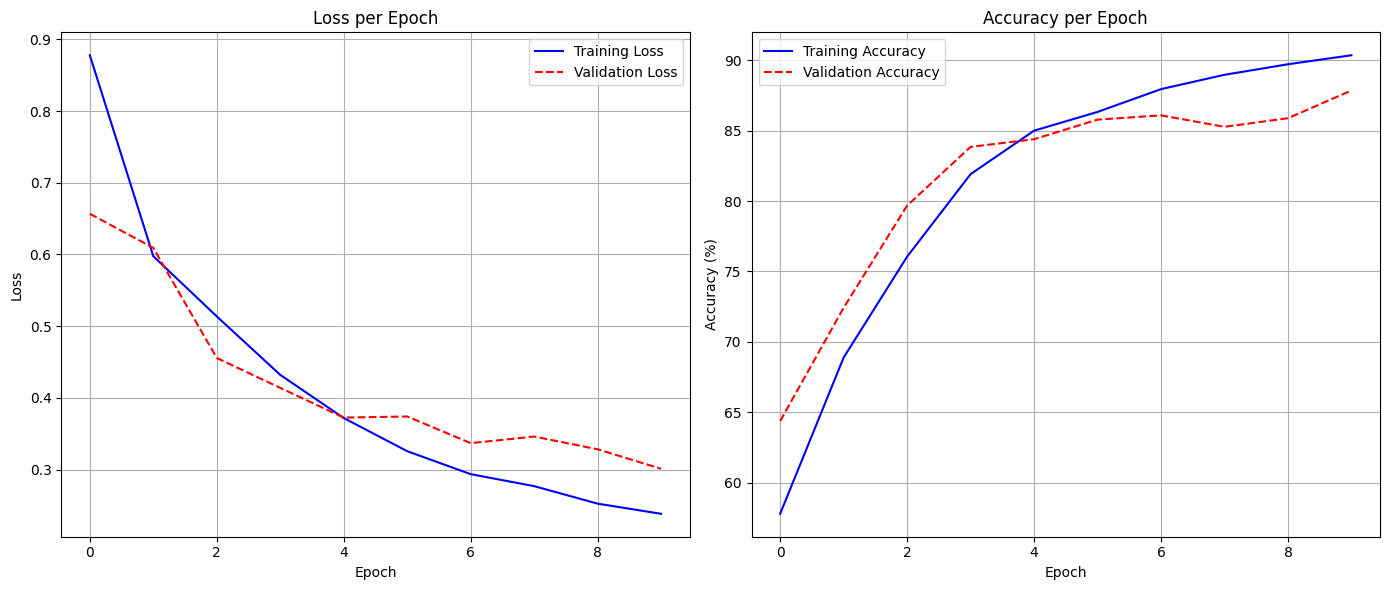

In [61]:
import matplotlib.pyplot as plt

# 학습 및 검증 결과 시각화
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째
plt.plot(epoch_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2) # 1행 2열 중 두 번째
plt.plot(epoch_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red', linestyle='--')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()